CREDIT CARD FRAUD DETECTION

In [94]:
#Importing necessary libraries

!pip install scipy
!pip install tensorflow
!pip install scikit-learn

In [95]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [96]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, Sequential

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [97]:
# Downloading and importing the dataset

df = pd.read_csv("/Users/piyushjain/Documents/Credit Card Fraud Detection Project/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset consists entirely of numerical variables. To protect privacy, the data has undergone PCA transformation(s). As a result, the original features have been converted into a set of principal components, preserving the data's overall structure while obfuscating any sensitive information.

In [98]:
#Checking the dimension of the dataset.

df.shape

(284807, 31)

In [99]:
# Checking for null values, if the ouput is false that means there are no null values.

df.isnull().values.any()

False

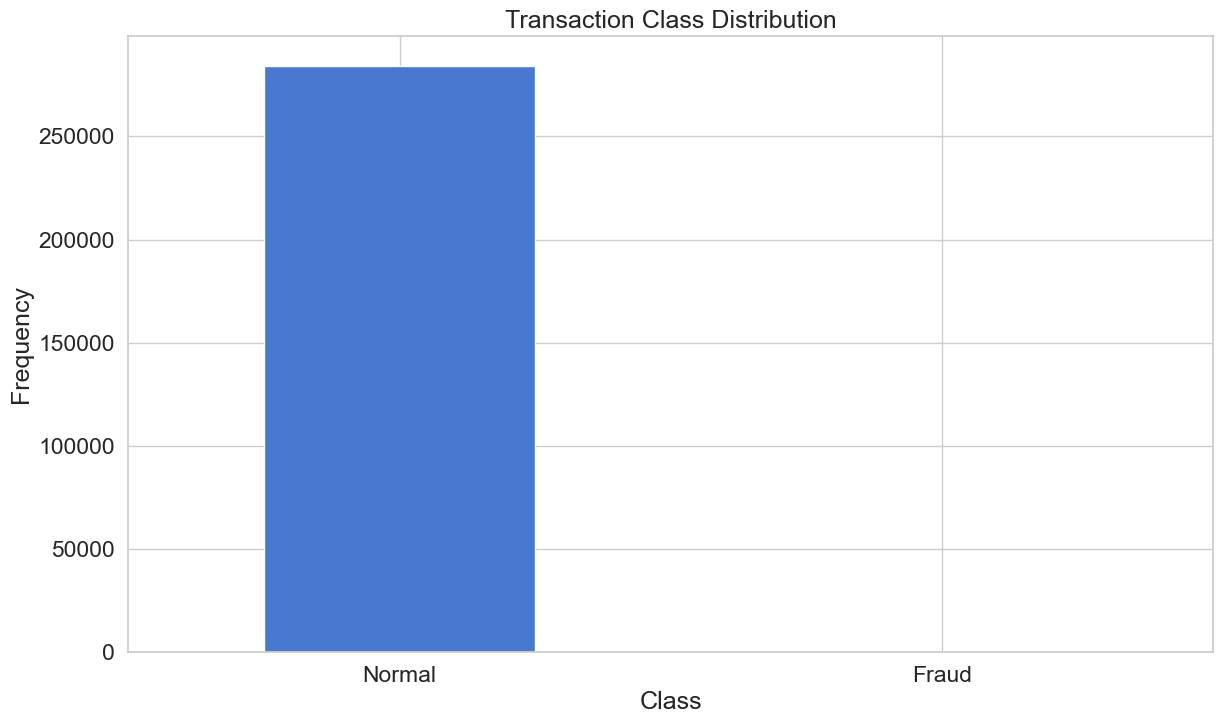

In [100]:
# Count the number of records for each class (0: Normal, 1: Fraud)
count_classes = pd.value_counts(df['Class'], sort=True)

# Plot the class distribution as a bar chart
count_classes.plot(kind='bar', rot=0)

# Set the title, x-axis and y-axis labels
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)  # Customizing x-axis labels (LABELS should be defined somewhere)
plt.xlabel("Class")
plt.ylabel("Frequency")
# Display the plot
plt.show()

In [101]:
'''
The dataset is highly imbalanced, with regards to the two transaction classes (fraud and non-fraud). 
After examining the dataset, we found that the 'frauds' subset, which contains transactions labeled 
as fraud (Class == 1), contains 1 record. Similarly, the 'normal' subset, which contains transactions 
labeled as non-fraud (Class == 0), has its own number of records.
'''
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

frauds_count = len(frauds)
normal_count = len(normal)

print("Number of fraud transactions:", frauds_count)
print("Number of non-fraud transactions:", normal_count)


Number of fraud transactions: 492
Number of non-fraud transactions: 284315


To check the amount of money involved in each kind of transaction (fraudulent and non-fraudulent), will be using descriptive statistics and visualize the distribution of transaction amounts for each class.

Fraudulent Transactions:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Non-Fraudulent Transactions:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


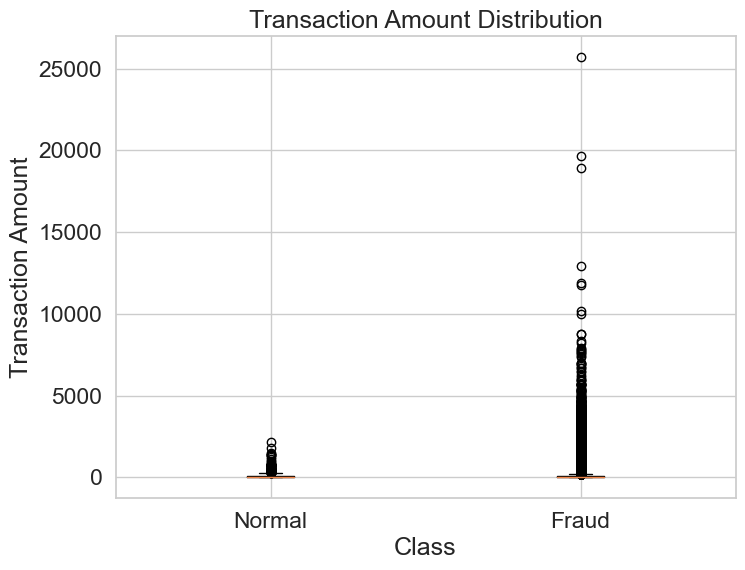

In [102]:
# Separate the fraudulent and non-fraudulent transactions
frauds = df[df['Class'] == 1]
normal = df[df['Class'] == 0]

# Summary statistics of the transaction amount for each class
fraud_amount_stats = frauds['Amount'].describe()
normal_amount_stats = normal['Amount'].describe()

# Print the summary statistics
print("Fraudulent Transactions:")
print(fraud_amount_stats)

print("\nNon-Fraudulent Transactions:")
print(normal_amount_stats)

# Visualize the distribution of transaction amounts for each class using box plots
plt.figure(figsize=(8, 6))
plt.boxplot([frauds['Amount'], normal['Amount']], labels=LABELS)
plt.title("Transaction Amount Distribution")
plt.xlabel("Class")
plt.ylabel("Transaction Amount")
plt.show()

Visualising the same with Bar graph for better understanding

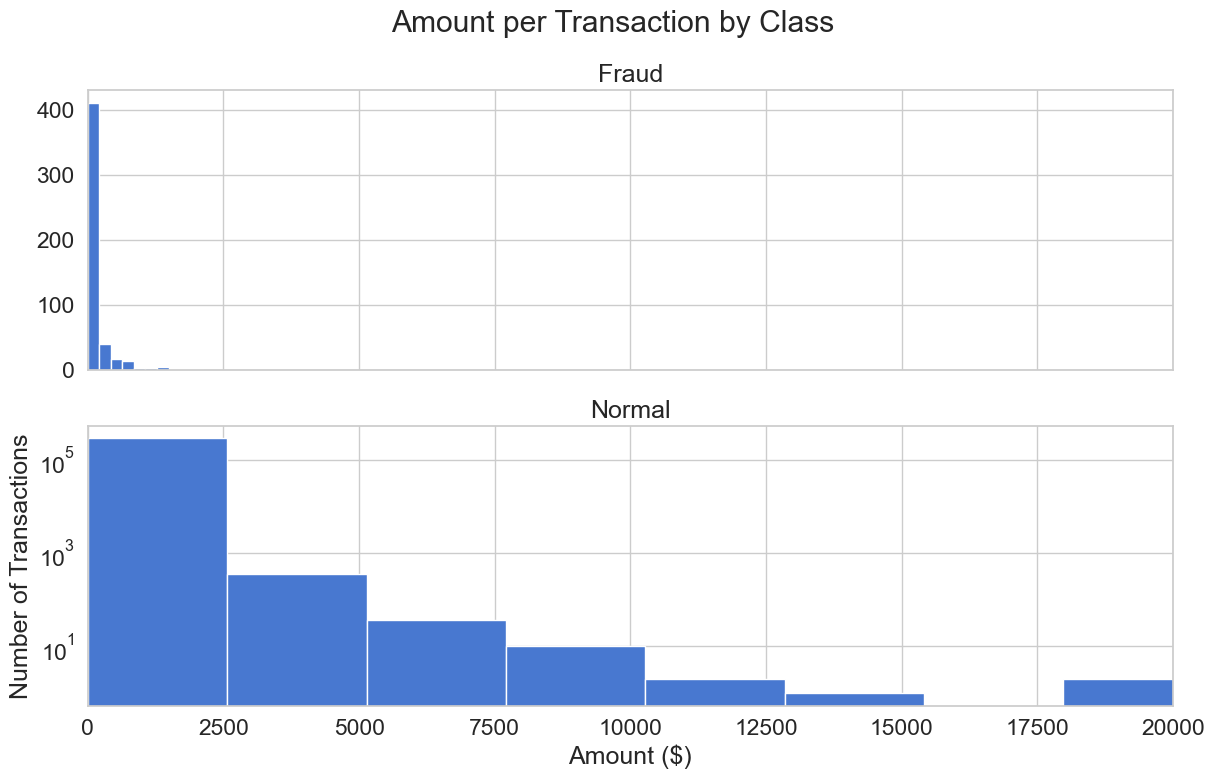

In [103]:
# Create a subplots grid with 2 rows and 1 column
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Set the title for the entire figure
f.suptitle('Amount per Transaction by Class')

# Number of bins for the histograms
bins = 10

# Plot the histogram for fraud transactions
ax1.hist(frauds['Amount'], bins=bins)
ax1.set_title('Fraud')

# Plot the histogram for normal transactions
ax2.hist(normal['Amount'], bins=bins)
ax2.set_title('Normal')

# Customize x-axis and y-axis labels
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')

# Set the x-axis limit from 0 to 20000
plt.xlim((0, 20000))

# Use logarithmic scale for the y-axis
plt.yscale('log')

# Display the plot
plt.show()

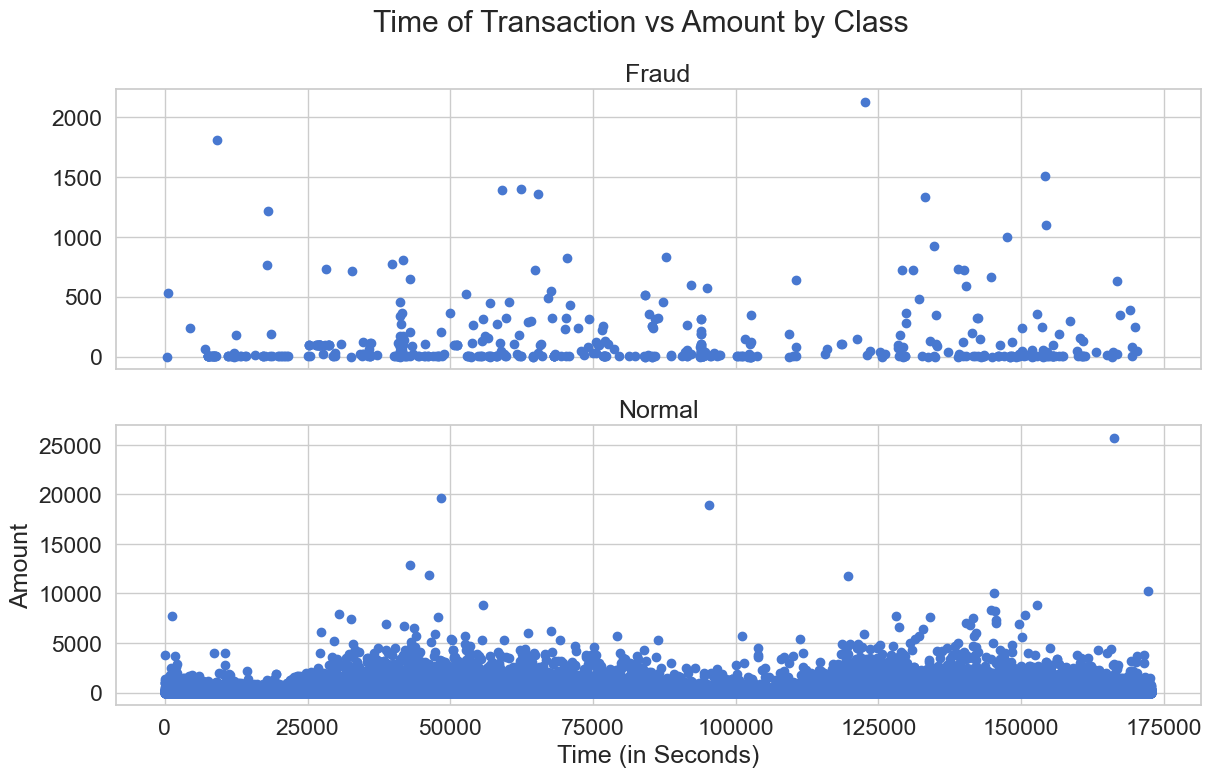

In [104]:
'''Creating two scatter plots side by side, showing the relationship between the time 
of transaction and the transaction amount for both fraudulent and non-fraudulent (normal) transactions. 
The plots will share the same x-axis, allowing for easy comparison of the two classes.'''

# Create a subplots grid with 2 rows and 1 column
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Set the title for the entire figure
f.suptitle('Time of Transaction vs Amount by Class')

# Plot the scatter plot for fraud transactions (Time vs Amount)
ax1.scatter(frauds['Time'], frauds['Amount'])
ax1.set_title('Fraud')

# Plot the scatter plot for normal transactions (Time vs Amount)
ax2.scatter(normal['Time'], normal['Amount'])
ax2.set_title('Normal')

# Customize x-axis and y-axis labels
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')

# Display the plot
plt.show()


In [105]:
'''The numerical amount in fraud and normal cases differ highly, therefore scaling the 'Amount' column 
will ensure that the features are on a similar scale, which will improve the performance and 
convergence of various machine learning algorithms.'''

from sklearn.preprocessing import StandardScaler

df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

In [106]:
'''In our fraud detection model, we will be using autoencoders. The main idea behind using autoencoders 
is to train the model to learn the best representation of non-fraudulent transactions. By doing so, it is 
expected of the model to automatically distinguish fraudulent transactions from the learned representation of 
non-fraudulent transactions.'''

#Separate the non-fraudulent and fraudulent transactions from the original dataset
non_fraud = df[df['Class'] == 0]
fraud = df[df['Class'] == 1]


# Combine both non-fraudulent and fraudulent transactions into a single DataFrame 'df' and shuffle the data
df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)

# Extract the feature vectors (X) and the corresponding labels (Y) from the combined and shuffled DataFrame 'df'
X = df.drop(['Class'], axis=1).values
Y = df["Class"].values


In [107]:
#Lets split the data into 80% training and 20% testing.

# Separate the features (X) and the target variable (y) from the 'data' DataFrame
X = df.drop(['Class'], axis=1)
y = df['Class']

# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (227845, 30)
X_test shape: (56962, 30)
y_train shape: (227845,)
y_test shape: (56962,)


In [108]:
'''Autoencoders are a type of neural network used for unsupervised learning, particularly in 
dimensionality reduction and feature learning tasks. They consist of an encoder and a decoder, 
which together form a bottleneck structure to compress and decompress the data, respectively.'''

# Input layer for the autoencoder
input_layer = Input(shape=(X.shape[1],))

## Encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## Decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## Output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

# Create the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
autoencoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_10 (Dense)            (None, 100)               3100      
                                                                 
 dense_11 (Dense)            (None, 50)                5050      
                                                                 
 dense_12 (Dense)            (None, 50)                2550      
                                                                 
 dense_13 (Dense)            (None, 100)               5100      
                                                                 
 dense_14 (Dense)            (None, 30)                3030      
                                                                 
Total params: 18830 (73.55 KB)
Trainable params: 18830 (73.

In [109]:
#Separating the features (x) and the target variable (y) from the DataFrame:
x = df.drop(["Class"], axis=1)
y = df["Class"].values

#Scaling the input data using MinMaxScaler:
from sklearn.preprocessing import MinMaxScaler
x_scale = MinMaxScaler().fit_transform(x.values)

#Separating non-fraudulent and fraudulent samples and assigning them to 'x_norm' and 'x_fraud', respectively:
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

#Fitting the autoencoder model using the non-fraudulent samples as both input and output data:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size=256, epochs=10, 
                shuffle=True, validation_split=0.20)


Epoch 1/10
7/7 [==============================] - 1s 10ms/step - loss: 0.2130 - val_loss: 0.1437
Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1419 - val_loss: 0.1335
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1318 - val_loss: 0.1286
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1284 - val_loss: 0.1273
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1270 - val_loss: 0.1256
Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1261 - val_loss: 0.1256
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1258 - val_loss: 0.1251
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1255 - val_loss: 0.1250
Epoch 9/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1254 - val_loss: 0.1248
Epoch 10/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1253 - val_loss: 0.1248


In [110]:
# Obtaining the hidden representation from the trained autoencoder model.

# Creating a new Sequential model named 'hidden_representation'
hidden_representation = Sequential()

# Adding the first three layers of the trained autoencoder model to 'hidden_representation'
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])


In [111]:
#Model Prediction for both non-fraudulent and fraudulent samples.

# Using the 'hidden_representation' model to predict the hidden representations for non-fraudulent samples
norm_hid_rep = hidden_representation.predict(x_norm[:3000])

# Using the 'hidden_representation' model to predict the hidden representations for fraudulent samples
fraud_hid_rep = hidden_representation.predict(x_fraud)


16/16 [==============================] - 0s 331us/step


In [112]:
# Combining the hidden representations of non-fraudulent and fraudulent samples
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis=0)

# Creating labels for the representations: 0 for non-fraudulent and 1 for fraudulent
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])

# Combining the labels for non-fraudulent and fraudulent samples
rep_y = np.append(y_n, y_f)


In [113]:
#Train, test, Split

# Split the representation data and labels into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)


In [114]:
# Train the Logistic Regression model using the training set
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)

# Predict the labels on the validation set
pred_y = clf.predict(val_x)

# Print the classification report
print("\nClassification Report:")
print(classification_report(val_y, pred_y))

# Print the accuracy score
print("\nAccuracy Score:", accuracy_score(val_y, pred_y))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       748
         1.0       1.00      0.65      0.79       125

    accuracy                           0.95       873
   macro avg       0.97      0.82      0.88       873
weighted avg       0.95      0.95      0.94       873


Accuracy Score: 0.9495990836197021


We get the classification report and accuracy score, and it provides insights into the model's performance on the credit card fraud detection task. 

The classification report will gives a detailed breakdown of metrics for each class:
1. Non-fraudulent or 0.0
2. Fraudulent or 1.0 

The accuracy score will gives an overall measure of the model's accuracy in correctly classifying samples.